In [1]:
import os
import glob

import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns

In [2]:
columns = ['id', 'prompt', 'generated_nl', 'gold_standard_nl', 'lang', 'model',
       'prompt_type', 'query', 'tokenized_generated_nl',
       'tokenized_gold_standard_nl', 'sentence_bleu', 'sentence_nist',
       'rougeL', 'levenshtein']

qald_9_test = pd.read_csv('../data/alpe-experiments/merged/qald-9-plus-test.tsv', sep='\t')
qald_9_train = pd.read_csv('../data/alpe-experiments/merged/qald-9-plus-train.tsv', sep='\t')
qald_10 = pd.read_csv('../data/alpe-experiments/merged/qald-10.tsv', sep='\t')

# Merge the datasets into one
merged_data = pd.concat([qald_9_test, qald_9_train, qald_10])
merged_data = merged_data[columns]

In [14]:
# List all directories in ../data/alpe-experiments/metrics
dirs = os.listdir('../data/alpe-experiments/metrics')

# Initialize an empty DataFrame
all_data = pd.DataFrame()

# Loop through each directory
for dir in dirs:
    # Get all .tsv files in the directory
    print(dir)
    tsv_files = glob.glob(f'../data/alpe-experiments/metrics/{dir}/*.tsv')
    
    # Loop through each .tsv file
    for file in tsv_files:
        # Read the .tsv file
        data = pd.read_csv(file, sep='\t')
        
        # Concatenate the data to all_data
        all_data = pd.concat([all_data, data])

merged_data = all_data[columns]

gpt-4-zeroshot
mistral-7b-oneshot
mistral-7b-oneshot-finetuned-new
gpt-3.5-oneshot
gpt-3.5-zeroshot
mistral-7b-zeroshot-finetuned
mistral-7b-zeroshot
gpt-3.5-oneshot-finetuned
gpt-4-oneshot
mistral-7b-oneshot-finetuned


In [15]:
merged_data[merged_data.model == "gpt-3.5-turbo"].prompt_type.value_counts()

ONE_SHOT     3758
ZERO_SHOT    3758
Name: prompt_type, dtype: int64

## All DSs visualization

In [16]:
# List of metrics to visualize
metrics = ['sentence_bleu', 'sentence_nist', 'rougeL', 'levenshtein']

# Rename metrics for better visualization
metric_names = {
    'sentence_bleu': 'Sentence BLEU',
    'sentence_nist': 'Sentence NIST',
    'rougeL': 'ROUGE-L',
    'levenshtein': 'Levenshtein',
    'Decision': 'Human Decision'
}

# Rename models for better visualization
model_names = {
    'gpt-3.5-turbo': 'GPT-3.5',
    'ft:gpt-3.5-turbo-0125:personal::9AfWwuZ3': 'GPT-3.5 FT',
    'gpt-4-1106-preview': 'GPT-4',
    'mistralai/Mistral-7B-Instruct-v0.2': 'Mistral-7B',
    'perevalov/Mistral-7B-instruct-v0.2-SPARQL2NL': 'Mistral-7B FT Old',
    'perevalov/Mistral-7B-instruct-v0.2-SPARQL2NL-10-04': 'Mistral-7B FT',
}

# Order the models for the visualization
order = ['GPT-3.5', 'GPT-3.5 FT', 'GPT-4', 'Mistral-7B', 'Mistral-7B FT']
vanilla = ['GPT-3.5', 'GPT-4', 'Mistral-7B']

merged_data['model'] = merged_data['model'].map(model_names)

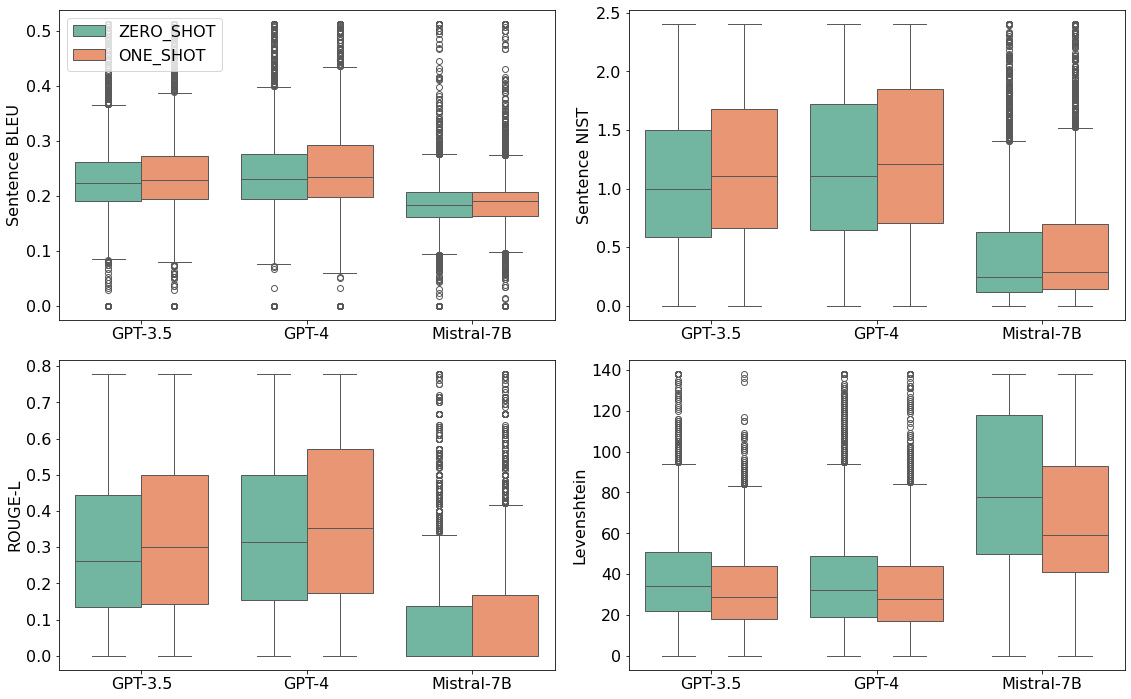

In [23]:
# Create a figure with 2x2 subplots
fig, axs = plt.subplots(2, 2, figsize=(16,10))


plt.rcParams.update({'font.size': 16, 'axes.titlesize': 16, 'axes.labelsize': 16, 'xtick.labelsize': 16, 'ytick.labelsize': 16})

# Reshape axs to 1D for easy iteration
axs = axs.ravel()

vanilla_merged_data = merged_data[merged_data.model.isin(vanilla)]

# Loop through each metric
for i, metric in enumerate(metrics):    
    # Clip values by 95%
    clipped_data = vanilla_merged_data[metric].clip(upper=vanilla_merged_data[metric].quantile(0.95))
    
    # Filter data for ONE_SHOT and ZERO_SHOT prompt types
    filtered_data = vanilla_merged_data[vanilla_merged_data['prompt_type'].isin(['ONE_SHOT', 'ZERO_SHOT'])]
    
    metric = metric_names[metric]
    
    # Create a bar plot for each model and prompt type
    sns.set_palette("Set2")
    sns.boxplot(x='model', y=clipped_data, hue='prompt_type', data=filtered_data, ax=axs[i], order=vanilla)
    # axs[i].set_title(f'Distribution of {metric} for each model and prompt type')
    axs[i].set_xlabel('')
    axs[i].set_ylabel(metric)
    if i == 0:
        axs[i].legend(loc="upper left")
    else: 
        axs[i].legend().remove()

plt.tight_layout()
plt.savefig("../data/res/prompt-types-vanilla.pdf")
plt.show()

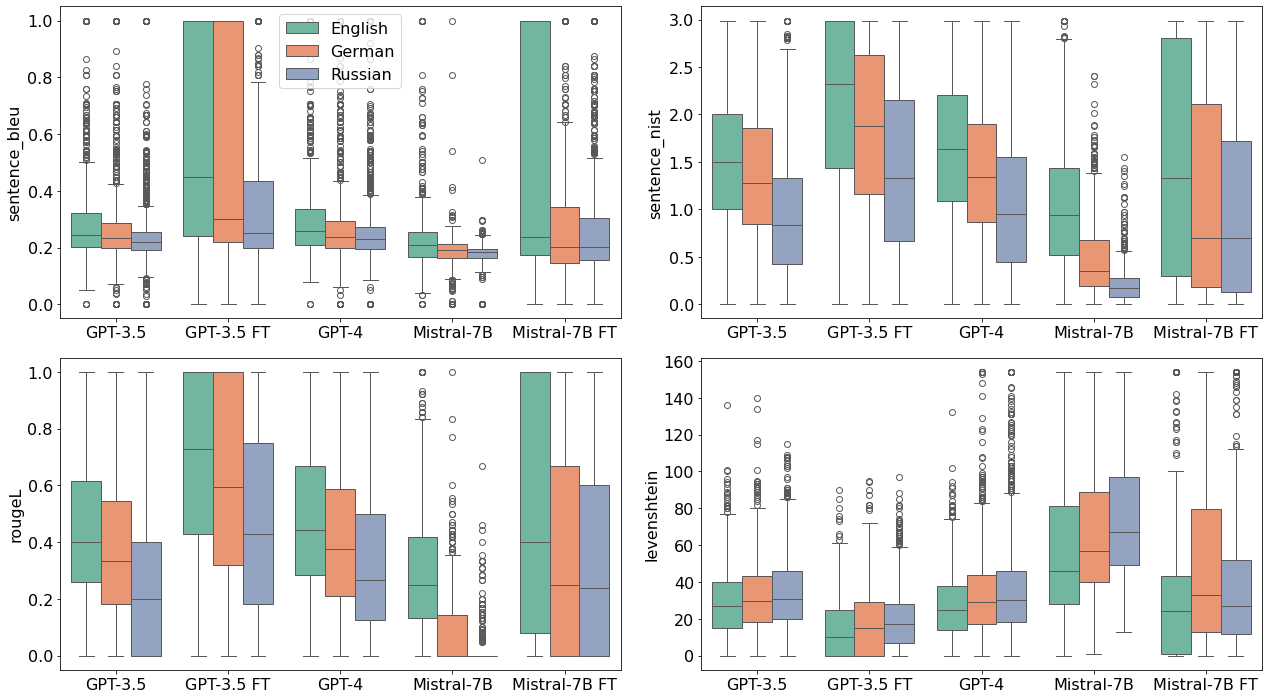

In [31]:
# Create a figure with 2x2 subplots
fig, axs = plt.subplots(2, 2, figsize=(18,10))

# Reshape axs to 1D for easy iteration
axs = axs.ravel()

order_merged_data = merged_data[merged_data.model.isin(order)]
order_merged_data = order_merged_data[(order_merged_data['prompt_type'].isin(['ONE_SHOT'])) & (order_merged_data['lang'].isin(['en', 'de', 'ru']))]

# Loop through each metric
for i, _metric in enumerate(metrics):
    # Clip values by 95%
    clipped_data = order_merged_data[_metric].clip(upper=order_merged_data[_metric].quantile(0.95))
    filtered_data = order_merged_data
    metric = order_merged_data[_metric]

    
    sns.boxplot(x='model', y=clipped_data, hue='lang', data=filtered_data, ax=axs[i], order=order, hue_order=['en', 'de', 'ru'])
    # axs[i].set_title(f'Distribution of {metric} for each model and language')
    
    handles, labels = axs[i].get_legend_handles_labels()

    axs[i].set_xlabel('')
    axs[i].set_ylabel(_metric)
    if i == 0:
        # axs[i].legend(loc="upper center")
        axs[i].legend(handles, ['English' , 'German', 'Russian'], loc="upper center")
    else: 
        axs[i].legend().remove()

plt.tight_layout()
plt.savefig("../data/res/languages.pdf")
plt.show()


# Qald 9 plus Train

# TODO: correlation with human analysis

In [15]:
import os 

# Create an empty DataFrame to store all the data
all_data = pd.DataFrame()

# Loop through each file in the directory
for file in os.listdir("../data/human-eval/"):
    df = pd.read_csv(f"../data/human-eval/{file}", sep='\t')
    df = df[df['Decision'].isin(['Yes', 'No'])]
    df.rename(columns={'language': 'lang'}, inplace=True)

    # Merge df and qald_9_test on 'id', 'lang', 'model', 'prompt'
    merged_df = pd.merge(df, qald_9_test, on=['id', 'lang', 'model', 'prompt'])
    # Convert 'Decision' column to integer type
    merged_df['Decision'] = merged_df['Decision'].map({'Yes': 1, 'No': 0})

    # Append the merged_df to all_data
    all_data = all_data.append(merged_df, ignore_index=True)

# Print the correlation of all_data
print(all_data[['sentence_bleu', 'sentence_nist', 'rougeL', 'levenshtein', 'Decision']][all_data.model=="gpt-4-1106-preview"].corr()["Decision"])
print(all_data[['sentence_bleu', 'sentence_nist', 'rougeL', 'levenshtein', 'Decision']][all_data.model=="gpt-3.5-turbo"].corr()["Decision"])
print(all_data[['sentence_bleu', 'sentence_nist', 'rougeL', 'levenshtein', 'Decision']][all_data.model=="mistralai/Mistral-7B-Instruct-v0.2"].corr()["Decision"])
print(all_data[['sentence_bleu', 'sentence_nist', 'rougeL', 'levenshtein', 'Decision']][all_data.model=="perevalov/Mistral-7B-instruct-v0.2-SPARQL2NL"].corr()["Decision"])

sentence_bleu    0.154960
sentence_nist    0.169312
rougeL           0.217723
levenshtein     -0.187537
Decision         1.000000
Name: Decision, dtype: float64
sentence_bleu    0.231772
sentence_nist    0.159646
rougeL           0.237324
levenshtein     -0.227122
Decision         1.000000
Name: Decision, dtype: float64
sentence_bleu    0.334091
sentence_nist    0.432255
rougeL           0.428123
levenshtein     -0.364822
Decision         1.000000
Name: Decision, dtype: float64
sentence_bleu    0.490897
sentence_nist    0.666445
rougeL           0.685185
levenshtein     -0.199562
Decision         1.000000
Name: Decision, dtype: float64


/tmp/ipykernel_23072/4019643266.py:18: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  all_data = all_data.append(merged_df, ignore_index=True)
/tmp/ipykernel_23072/4019643266.py:18: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  all_data = all_data.append(merged_df, ignore_index=True)
/tmp/ipykernel_23072/4019643266.py:18: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  all_data = all_data.append(merged_df, ignore_index=True)
/tmp/ipykernel_23072/4019643266.py:18: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  all_data = all_data.append(merged_df, ignore_index=True)
/tmp/ipykernel_23072/4019643266.py:18: FutureWarning: The frame.append metho

In [25]:
all_data[all_data.Decision == 1][['sentence_bleu', 'sentence_nist', 'rougeL', 'levenshtein']].describe()

,sentence_bleu,sentence_nist,rougeL,levenshtein
count,694.000000,694.000000,694.000000,694.000000
mean,0.290232,1.384048,0.429923,33.867435
std,0.178245,0.726472,0.262520,26.512536
min,0.000000,0.000000,0.000000,0.000000
25%,0.198300,0.807850,0.235300,17.000000
50%,0.234200,1.281700,0.381000,28.000000
75%,0.293200,1.993200,0.615400,45.000000
max,1.000000,3.329400,1.000000,226.000000


In [26]:
all_data[all_data.Decision == 0][['sentence_bleu', 'sentence_nist', 'rougeL', 'levenshtein']].describe()

,sentence_bleu,sentence_nist,rougeL,levenshtein
count,314.000000,314.000000,314.000000,314.000000
mean,0.204221,0.950218,0.255500,68.847134
std,0.068372,0.627824,0.198153,75.604458
min,0.032900,0.052800,0.000000,7.000000
25%,0.162175,0.473275,0.111100,34.000000
50%,0.198050,0.817450,0.222200,51.000000
75%,0.236675,1.268000,0.379500,75.000000
max,0.607700,2.839500,0.857100,889.000000


In [5]:
from rdflib.plugins.sparql.parser import parseQuery

In [6]:
def add_query_params_to_df(query, df):
    try:
        parse_results = parseQuery(query)
        # Add prefix presence
        df['prefix_presence'] = len(parse_results[0]) > 0
        # Add presence of projection
        df['query_type'] = 'SELECT' if 'projection' in parse_results[1].keys() else 'ASK'
        # Add num of triples
        df['num_of_triples'] = len(parse_results[1]['where']['part'][0]['triples'][0])//3 if 'triples' in parse_results[1]['where']['part'][0].keys() else 0
        # Add presence of orderby
        df['orderby_presence'] = 'orderby' in parse_results[1].keys()
        # Add presence of limitoffset
        df['limitoffset_presence'] = 'limitoffset' in parse_results[1].keys()
        # Add presence of having
        df['having_presence'] = 'having' in parse_results[1].keys()
    except:
        print("Error in parsing the query")
        df['prefix_presence'] = 0
        df['query_type'] = 0
        df['num_of_triples'] = 0
        df['orderby_presence'] = False
        df['limitoffset_presence'] = False
        df['having_presence'] = False
        return df

    return df
# Assuming the other datasets are named as qald_9_train, qald_10.
datasets = [qald_9_test, qald_9_train, qald_10]
new_datasets = []
for dataset in datasets:
    print("1")
    dataset = dataset.apply(lambda row: add_query_params_to_df(row['query'], row), axis=1)
    new_datasets.append(dataset)

# Merge the datasets into one
merged_datasets = pd.concat(new_datasets, ignore_index=True)

1
1
1
Error in parsing the query


In [8]:
# Analyse the query metrics like prefix_presence wr.t. the generaton metrics e.g. sentence_bleu, sentence_nist, rougeL, levenshtein
metrics = ['sentence_bleu', 'sentence_nist', 'rougeL', 'levenshtein']
features = ['prefix_presence', 'query_type', 'num_of_triples', 'orderby_presence', 'limitoffset_presence', 'having_presence']

# Calculate the correlation matrix between the metrics and features
corr_matrix = merged_datasets[metrics + features].corr()

# Display the correlation matrix
# print(corr_matrix)

/tmp/ipykernel_71132/3206579275.py:6: FutureWarning: The default value of numeric_only in DataFrame.corr is deprecated. In a future version, it will default to False. Select only valid columns or specify the value of numeric_only to silence this warning.
  corr_matrix = merged_datasets[metrics + features].corr()


In [7]:
for m in metrics:
    merged_datasets[m] = merged_datasets[m].clip(upper=merged_datasets[m].quantile(0.95))

In [10]:
metrics

['sentence_bleu', 'sentence_nist', 'rougeL', 'levenshtein', 'Decision']

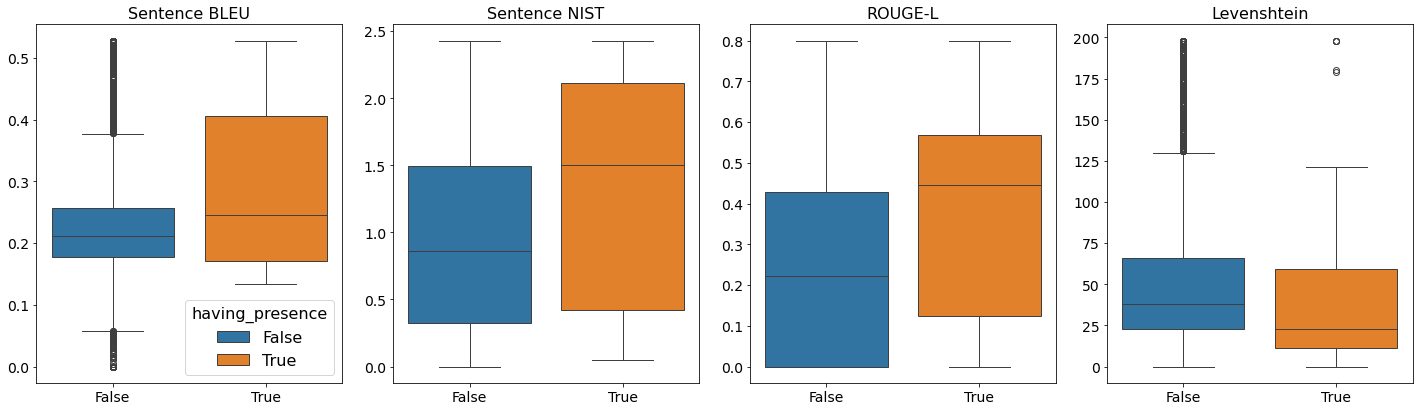

In [14]:
# Import necessary libraries
import matplotlib.pyplot as plt
import seaborn as sns


query_param = 'having_presence'#, 'query_type', 'num_of_triples', 'orderby_presence', 'limitoffset_presence', 'having_presence']

plt.rcParams.update({'font.size': 16, 'axes.titlesize': 16, 'axes.labelsize': 16, 'xtick.labelsize': 14, 'ytick.labelsize': 14})
# Change the subplot configuration to have all plots in one row
fig, axs = plt.subplots(1, len(metrics), figsize=(5*len(metrics), 6))

# Create a subplot for each metric
# fig, axs = plt.subplots(len(metrics), figsize=(10, 6*len(metrics)))

for i, metric in enumerate(metrics):
    merged_datasets = merged_datasets[merged_datasets.num_of_triples > 0]
    if metric == 'Decision':
        sns.countplot(x=query_param, hue=metric, data=merged_datasets, ax=axs[i], log_scale=True)
        # sns.countplot(x=query_param, hue=metric, data=merged_datasets, ax=axs[i], log)
        axs[i].set_xticklabels(['False', 'True'])
        #sns.scatterplot(x=query_param, y=metric, size=metric, hue=query_param, data=merged_datasets, ax=axs[i], sizes=(200, 800))
        # axs[i].set_xticklabels(['False', 'True'])
    else:
        sns.boxplot(x=query_param, y=metric, data=merged_datasets, hue=query_param, ax=axs[i])
    # sns.boxplot(x=query_param, y=metric, data=merged_datasets, ax=axs[i])
    axs[i].set_xlabel("")
    metric = metric_names[metric]
    axs[i].set_title(f'{metric}')
    axs[i].set_ylabel("")
    if i > 0:
        axs[i].legend().remove()

plt.tight_layout()
plt.savefig(f"../data/res/{query_param}.pdf")
plt.show()

# Metric optimization

In [8]:
from sklearn.model_selection import train_test_split
from sklearn.ensemble import RandomForestClassifier
from sklearn.metrics import classification_report
from sklearn.linear_model import LogisticRegression



# Define the features and the target
X = all_data[['sentence_bleu', 'sentence_nist', 'rougeL', 'levenshtein']]
y = all_data['Decision']

# Split the data into training and testing sets
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

# Initialize the RandomForestClassifier
clf = LogisticRegression(random_state=42)

# Fit the model to the training data
clf.fit(X_train, y_train)

# Predict the labels of the test set
y_pred = clf.predict(X_test)

# Print the classification report
print(classification_report(y_test, y_pred))

from sklearn.inspection import permutation_importance

# perform permutation importance
results = permutation_importance(clf, X_test, y_test, scoring='accuracy')
# get importance
importance = results.importances_mean
# summarize feature importance
for i,v in enumerate(importance):
    print('Feature: %0d, Score: %.5f' % (i,v))


              precision    recall  f1-score   support

           0       0.52      0.20      0.29        60
           1       0.73      0.92      0.82       142

    accuracy                           0.71       202
   macro avg       0.63      0.56      0.55       202
weighted avg       0.67      0.71      0.66       202

Feature: 0, Score: -0.00099
Feature: 1, Score: 0.01188
Feature: 2, Score: 0.01386
Feature: 3, Score: 0.01881
